# Анализ сервиса аренды самокатов GoFast

**Описание проекта:**

Мы анализируем работу сервиса аренды самокатов **GoFast**. Нам были переданы данные о некоторых пользователях из нескольких городов, а также об их поездках.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

- без подписки
 - абонентская плата отсутствует
 - стоимость одной минуты поездки — 8 рублей
 - стоимость старта (начала поездки) — 50 рублей
 
- С подпиской Ultra
 - абонентская плата — 199 рублей в месяц
 - стоимость одной минуты поездки — 6 рублей
 - стоимость старта — бесплатно
 
 
**Цель проекта:**

Проанализировать данные и проверить гипотезы:

- Тратят ли пользователи с подпиской больше времени на поездки?
- Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**Описание данных:**

- **users_go**
 - **user_id** - уникальный идентификатор пользователя
 - **name** - имя пользователя
 - **age** - возраст
 - **city** - город
 - **subscription_type** - тип подписки (free, ultra)
- **rides_go**
 - **user_id** - уникальный идентификатор пользователя
 - **distance** - расстояние, которое пользователь проехал в текущей сессии (в метрах)
 - **duration** - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
 - **date** - дата совершения поездки
- **subscriptions_go**
 - **subscription_type** - тип подписки
 - **minute_price** - стоимость одной минуты поездки по данной подписке
 - **start_ride_price** - стоимость начала поездки
 - **subscription_fee** - стоимость ежемесячного платежа
 
**План работы:**

[1. Загрузка данных](#section_1)

[2. Предобработка данных](#section_2)

[3. Исследовательский анализ данных](#section_3)

[4. Объединение данных](#section_4)

[5. Подсчёт выручки](#section_5)

[6. Проверка гипотез](#section_6)

[7. Распределения](#section_7)

[8. Общий вывод](#section_8)


In [1]:
#Загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
from scipy import stats as st
from scipy.stats import binom
from matplotlib import pyplot as plt
from numpy import random

## Загрузка данных 
<a id='section_1'></a>

In [2]:
#Загрузка датафреймов
users_go = pd.read_csv('/datasets/users_go.csv')
rides_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
#Общая информация users
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
#Первые 10 строк users
users_go.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [5]:
#Общая информация rides
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
#Первые 10 строк rides
rides_go.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [7]:
#Общая информация subscriptions
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [8]:
#Вся таблица subscriptions
subscriptions_go

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


### Промежуточный вывод после загрузке данных
**users_go** - 1565 записей, пропусков нет.

**rides_go** - 18068 записей, пропусков нет, требуется изменение типа данных в столбце **date** на *datetime*.

**subscriptions_go** - 2 записи, пропусков нет.

## Предобработка данных
<a id='section_2'></a>

In [9]:
#Кол-во дубликтов в users
users_go.duplicated().sum()

31

In [10]:
#Удалене повторяющихся строк в users
users_go = users_go.drop_duplicates().reset_index(drop=True)

In [11]:
#Кол-во дубликатов в rides
rides_go.duplicated().sum()

0

In [12]:
#Изменение типа данных в столбцу date в таблице rides
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

Прежде чем создать столбец с номерами месяцев, проверим за какой период в годах предоставлены данные.

In [13]:
#Проверка за какие года предоставлены данные
rides_go['date'].dt.year.value_counts()

2021    18068
Name: date, dtype: int64

Выборка предоставлена только за 2021 год, столбец с годами не нужен.

In [14]:
#Создание нового столбца
rides_go['month'] = rides_go['date'].dt.month

In [15]:
#Визуализация результатов
rides_go.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


На всякий случай проверю названия городов и имена на неявные дубликаты.

In [16]:
#Уникальные значения названий городов
users_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [17]:
#Уникалные значения имен пользователей
users_go['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [18]:
#Общая информация для users после предобработки
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


In [19]:
#Общая информация для rides после предобработки
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


### Промежуточный вывод после предобработки данных:
- **users_go**
 - Удален 31 дубликат.
 - Были проверены столбцы **city** и **name** на неявные дубликаты, аномалий найдено не было.
- **rides_go**
 - Тип данных столбца **date** изменен на *datetime*.
 - Вся выбока только за 2021 год.
 - Создан столбец с номером месяца поездки.

## Исследовательский анализ данных
<a id='section_3'></a>

Кол-во пользователей по городам:

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


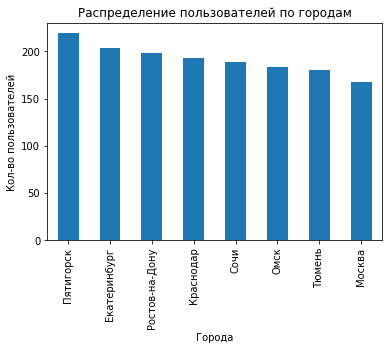

In [20]:
#Кол-во пользователей из каждого города
print(f'Кол-во пользователей по городам:\n')
print(users_go['city'].value_counts().sort_values(ascending = False))
users_go['city'].value_counts().plot(x='city',
                                     kind='bar',
                                     title='Распределение пользователей по городам',
                                     xlabel = 'Города', ylabel = 'Кол-во пользователей')
plt.show()



Больше всего пользуются арендой самокатов в более южных городах, где сезон проката больше, станно на этом фоне выглят Екатеринбург, который даже севернее Москвы.

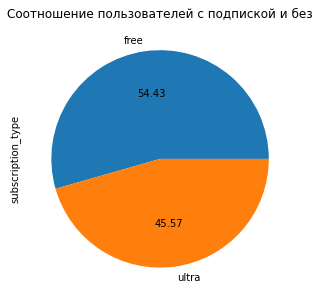

В абсолютных числах:


free     835
ultra    699
Name: subscription_type, dtype: int64

In [21]:
#Пользователи с подпиской и без
users_go['subscription_type'].value_counts().plot(kind='pie', autopct='%.2f',
                                                  title='Соотношение пользователей с подпиской и без',
                                                  figsize=(5,5))


plt.show()

print('В абсолютных числах:')
users_go['subscription_type'].value_counts().sort_values(ascending = False)

Пользователей с подпиской меньше (45%), чем пользователей без подписки (55%).

In [22]:
#Описание данных столбцов age, distance и duration таблицы rides
users_go[['user_id', 'age']].merge(rides_go[['user_id', 'distance', 'duration']])[['age', 'distance', 'duration']].describe()

,age,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,24.893071,3070.659976,17.805011
std,4.582216,1116.831209,6.091051
min,12.000000,0.855683,0.500000
25%,22.000000,2543.226360,13.597563
50%,25.000000,3133.609994,17.678395
75%,28.000000,3776.222735,21.724800
max,43.000000,7211.007745,40.823963


In [23]:
#Функция для создания сетки на нескольких графиках
def grid_on(ax):
    for row in ax:
        for ax in row:
            ax.grid(True)

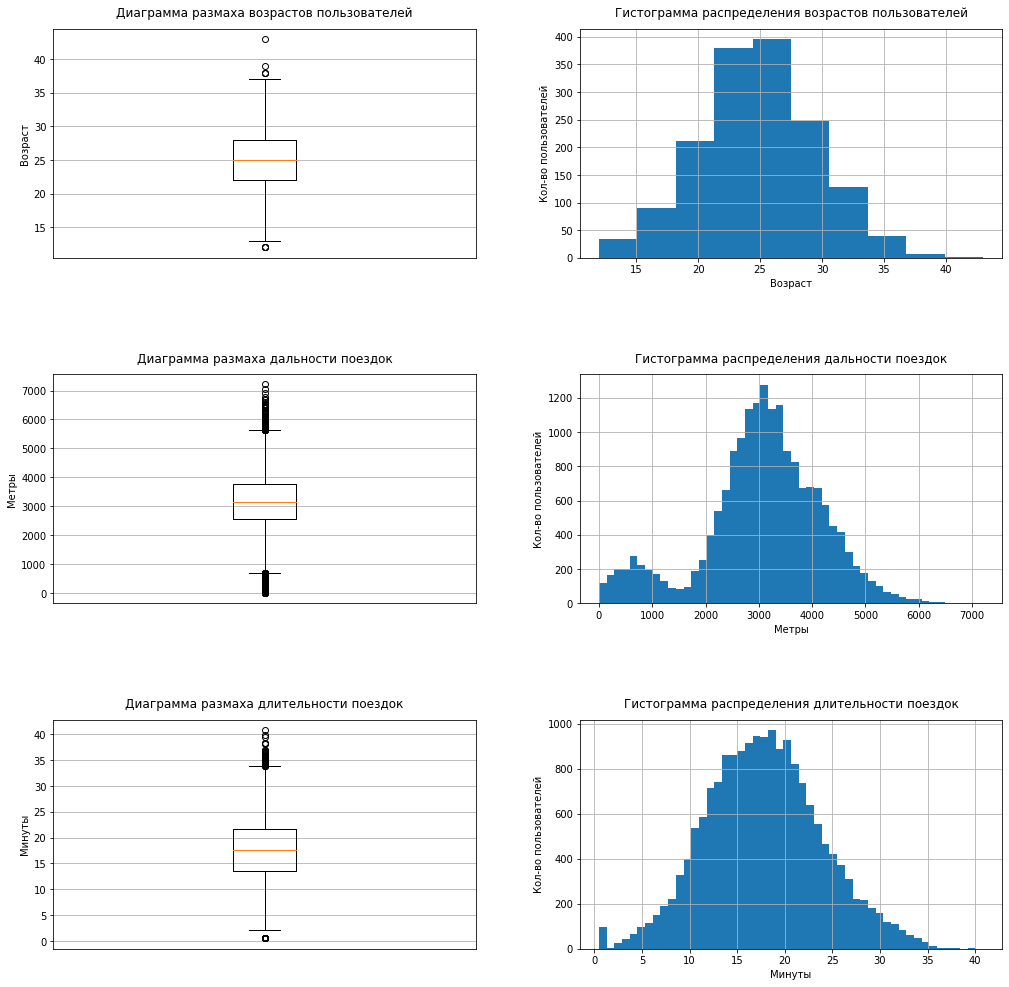

In [24]:
#Cоздание графиков
fig_1, ax_1 = plt.subplots(3, 2)
fig_1.tight_layout(h_pad=1)
fig_1.set_figheight(15)
fig_1.set_figwidth(15)
grid_on(ax_1)

#Присвоение названий графикам для более удобной работы
age_span = ax_1[0, 0]
age_hist = ax_1[0, 1]
distance_span = ax_1[1, 0]
distance_hist = ax_1[1, 1]
duration_span = ax_1[2, 0]
duration_hist = ax_1[2, 1]

#Заголовки
age_span.set_title('Диаграмма размаха возрастов пользователей', pad=12)
age_hist.set_title('Гистограмма распределения возрастов пользователей', pad=12)
distance_span.set_title('Диаграмма размаха дальности поездок', pad=12)
duration_span.set_title('Диаграмма размаха длительности поездок', pad=12)
distance_hist.set_title('Гистограмма распределения дальности поездок', pad=12)
duration_hist.set_title('Гистограмма распределения длительности поездок', pad=12)

#Подписи к осям графиков
age_span.axes.get_xaxis().set_visible(False)
age_span.set_ylabel('Возраст')
age_hist.set_xlabel('Возраст')
age_hist.set_ylabel('Кол-во пользователей')
distance_span.axes.get_xaxis().set_visible(False)
distance_span.set_ylabel('Метры')
distance_hist.set_xlabel('Метры')
distance_hist.set_ylabel('Кол-во пользователей')
duration_span.axes.get_xaxis().set_visible(False)
duration_span.set_ylabel('Минуты')
duration_hist.set_xlabel('Минуты')
duration_hist.set_ylabel('Кол-во пользователей')

#Нанесение на графики данных
age_span.boxplot(users_go['age'])
age_hist.hist(users_go['age'])
distance_span.boxplot(rides_go['distance'])
duration_span.boxplot(rides_go['duration'])
distance_hist.hist(rides_go['distance'], bins=50)
duration_hist.hist(rides_go['duration'], bins=50)




plt.show()

**Возраст пользователей:**
- Распределение стремится к нормальному.
- Наибоолее распространенный возраст - 25 лет, минимальный - 12 лет, максимальный - 43 года, большинство пользователй находится в диапазоне от 20 лет до 30 лет.

**Дальность поездок:**
- Есть два всплеска на 600 м и 3000 м.
- Распределение стремится к нормальному, если не считать первый всплеск.
- Большинство поездок находятся в диапазоне от 2500 м до 4000 м, медиана на 3100 м, первый квартиль - 2550 м, третий квартиль - 3800 м, минимальная дальность поездки - 1 м (видимо человек передумал), максимальная - 7200 м.

**Длительность поездок**
- Распределение стремится к нормальному.
- Большинство поездок находится в дипазоне от 10 мин до 25 мин, медиана - 18 мин, первый квартиль - 14 мин, третий квартиль - 22 мин, минисальная длительность поездки - 0.5 мин, максимальная - 41 мин.
- Есть аномальный всплеск на нуле, нужно проверить.

In [25]:
rides_go.query('distance < 50')

,user_id,distance,duration,date,month
6611,707,28.793204,14.143966,2021-09-12,9
6691,712,23.963062,2.053251,2021-11-22,11
6850,724,30.473763,3.166221,2021-05-09,5
7389,762,35.061903,7.087655,2021-05-27,5
7841,796,7.097072,10.026614,2021-11-26,11
8324,835,12.233115,4.034952,2021-09-19,9
8658,861,6.784447,6.015656,2021-07-21,7
8906,880,11.283615,2.035632,2021-03-28,3
9128,896,31.803410,8.079509,2021-03-16,3
9439,918,38.711151,11.165905,2021-06-08,6


Вероятно в каждой поездке дальностью меньше 50 м, пользователь передумал куда-либо ехать, оставим эти данные без изменений.

In [26]:
#Срез с аномалией
rides_go.query('duration <= 1').sort_values('distance')

,user_id,distance,duration,date,month
15132,1325,4030.308008,0.5,2021-12-22,12
17909,1524,4103.998874,0.5,2021-06-18,6
10692,1006,4106.278268,0.5,2021-10-31,10
9698,937,4169.066800,0.5,2021-12-12,12
14342,1268,4177.139336,0.5,2021-06-09,6
...,...,...,...,...,...
14574,1285,6316.574814,0.5,2021-09-25,9
13701,1224,6414.516026,0.5,2021-07-15,7
11385,1057,6601.197575,0.5,2021-02-07,2
17242,1477,6724.932981,0.5,2021-01-12,1


Взял разрез по длительности поездок меньше минуты. По этому разрезу видно, что минимальная дистанция при такой длительности поездки составляет 4 км, за пол минуты такое расстояние проехать невозможно, а вот за пол часа вполне. Делаем вывод, что в этом срезе, время указано в часах, исправим эту аномалию.

In [27]:
#Исправление аномалии
rides_go.loc[rides_go['duration']==0.5, 'duration'] = rides_go['duration']*60

In [28]:
#users после предобработки
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


In [29]:
#rides после предобработки
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


### Промежуточный вывод после исследовательского анализа данных
**Распределение пользователей по городам:**
- Больше всего пользуются арендой самокатов вболее южных городах, где сезон проката больше, станно на этом фоне выглят Екатеринбург, который даже севернее Москвы.

**Распределение пользователей по типу подписки:**
- Пользователей с подпиской меньше (45%), чем пользователей без подписки (55%).

**Возраст пользователей:**
- Распределение стремится к нормальному.
- Наибоолее распространенный возраст - 25 лет, минимальный - 12 лет, максимальный - 43 года, большинство пользователй находится в диапазоне от 20 лет до 30 лет.

**Дальность поездок:**
- Есть два всплеска на 600 м и 3000 м.
- Распределение стремится к нормальному, если не считать первый всплеск.
- Большинство поездок находятся в диапазоне от 2500 м до 4000 м, медиана на 3100 м, первый квартиль - 2550 м, третий квартиль - 3800 м, минимальная дальность поездки - 1 м (видимо человек передумал), максимальная - 7200 м.

**Длительность поездок**
- Распределение стремится к нормальному.
- Большинство поездок находится в дипазоне от 10 мин до 25 мин, медиана - 18 мин, первый квартиль - 14 мин, третий квартиль - 22 мин, минисальная длительность поездки - 0.5 мин, максимальная - 41 мин.
- Была исправлена аномалия с поезками в пол минуты, оказалось время в некоторых строках было указано в часах.

## Объединение данных
<a id='section_4'></a>

In [30]:
#Объединение данных из трех таблиц в одну
full_data = users_go.merge(rides_go, on='user_id').merge(subscriptions_go, on='subscription_type')

In [31]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [32]:
#Первые 20 строк data
full_data.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Оъединение таблиц прошло корректно, кол-во строк соответствует кол-ву строк датафрейма **rides_go**, пропущенных значений нет.

In [33]:
#Создание таблицы пользователей с подпиской
full_data_ultra = full_data[full_data['subscription_type'] == 'ultra'].reset_index(drop=True)

In [34]:
#Общая информация full_data_ultra
full_data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 609.5+ KB


In [35]:
#Первые 20 строк full_data_ultra
full_data_ultra.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [36]:
#Создание таблицы пользователей без подписки
full_data_free = full_data[full_data['subscription_type'] == 'free'].reset_index(drop=True)

In [37]:
#Общая информация full_data_free
full_data_free.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11568 entries, 0 to 11567
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


In [38]:
#Первые 20 строк full_data_free
full_data_free.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
5,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
7,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
8,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
9,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


В **full_data_ultra** 6500 записей, в **full_data_free** 11568 записей, суммарно в двух датафреймах 18068 записей, это число соответствует числу записей исходного датафрейма, создание датафремов прошло корректно.

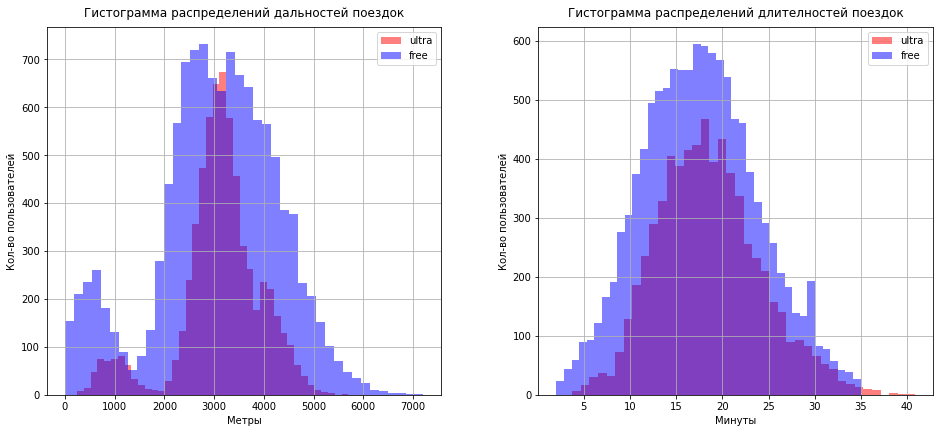

In [39]:
fig_2, ax_2 = plt.subplots(1, 2)
fig_2.tight_layout(h_pad=1)
fig_2.set_figheight(6)
fig_2.set_figwidth(14)

for ax in ax_2:
    ax.grid(True)

distances_hist = ax_2[0]
durations_hist = ax_2[1]

distances_hist.set_title('Гистограмма распределений дальностей поездок', pad=10)
durations_hist.set_title('Гистограмма распределений длителностей поездок', pad=10)

distances_hist.set_xlabel('Метры')
distances_hist.set_ylabel('Кол-во пользователей')
durations_hist.set_xlabel('Минуты')
durations_hist.set_ylabel('Кол-во пользователей')

distances_hist.hist(full_data_ultra['distance'], bins=40, alpha=0.5, color='red', label='ultra')
distances_hist.hist(full_data_free['distance'], bins=40, alpha=0.5, color='blue', label='free')
distances_hist.legend()

durations_hist.hist(full_data_ultra['duration'], bins=40, alpha=0.5, color='red', label='ultra')
durations_hist.hist(full_data_free['duration'], bins=40, alpha=0.5, color='blue', label='free')
durations_hist.legend()

plt.show()

In [40]:
#Описание данных столбцов с дистанцией и длительностью поездок для пользователей с подпиской и без нее
ultra_desc = full_data_ultra[['distance', 'duration']].describe()
free_desc = full_data_free[['distance', 'duration']].describe()

ultra_desc.columns = [['distance_ultra', 'duration_ultra']]
free_desc.columns = [['distance_free', 'duration_free']]

full_desc = ultra_desc.join(free_desc)
full_desc = full_desc[['distance_ultra', 'distance_free', 'duration_ultra', 'duration_free']]

full_desc

,distance_ultra,distance_free,duration_ultra,duration_free
count,6500.000000,11568.000000,6500.000000,11568.000000
mean,3115.445388,3045.495282,18.541985,17.633172
std,836.895330,1246.173806,5.572048,6.239577
min,244.210438,0.855683,3.760353,2.035632
25%,2785.444017,2366.562689,14.524654,13.127082
50%,3148.637229,3114.648465,18.178153,17.446822
75%,3560.574425,3905.697894,21.884129,21.779484
max,5699.769662,7211.007745,40.823963,34.948498


### Промежуточный вывод после объединениея  данных

1. Был создан датафрем с объединенными данными из исходных.
2. Из объединенного датафрейма было создано 2 датафрема: в одном пользователи с подпиской, в другом без подписки.

**ultra:**
- Дальность поездок имеют два всплеска на 1000 м и 3000 м, большинство поездок в диапазоне от 2500 м до 4000 м, минимальная дальность - 244 м, максимальная дальность - 5700 м, медиана 3150 м, первый квартиль - 2800 м, третий квартиль 3560 м, стандартное отклонение 837 м.
- Длительность поездок нормально распределена, большинство поездок находится в диапазоне от 10 мин до 25 мин, минимальная длительность - 4 мин, максимальная - 41 мин, медиана - 18 мин, первый квартиль - 14 мин, третий квартиль - 22 мин, стандартное отклонение - 5.6 мин

**free:**
- Дальность поездок имеют два всплеска на 500 м и 3000 м, большинство поездок в диапазоне от 2000 м до 5000 м, минимальная дальность - 1 м, максимальная дальность - 7200 м, медиана 3100 м, первый квартиль - 2400 м, третий квартиль 3900 м, стандартное отклонение 1246 м.
- Длительность поездок нормально распределена, большинство поездок находится в диапазоне от 5 мин до 30 мин, минимальная длительность - 2 мин, максимальная - 35 мин, медиана - 17 мин, первый квартиль - 13 мин, третий квартиль - 22 мин, стандартное отклонение 6 мин.

**Сравнение ultra и free:**
- Дальности поездок пользователей без подписки сильнее разбросаны, чем дальности поездок пользователей с подпиской, медианы и средние примерно равны минимальная дальность у пользователей с подпиской больше, чем у пользователей без подписки, а максимальная наоборот меньше.
- Длительности поездок пользователей без подписки чуть сильнее разбросаны, чем длительности поездок пользователей с подпиской, медианы и средние примерно равны, минимальная и максимальная длительность у пользователей с подпиской больше, чем у пользователей без подписки.

## Подсчёт выручки
<a id='section_5'></a>

In [41]:
#Округление длительностей поездок
full_data['duration'] = np.ceil(full_data['duration'])

In [42]:
#Проверка округления
full_data['duration'].head()

0    26.0
1    16.0
2     7.0
3    19.0
4    27.0
Name: duration, dtype: float64

In [43]:
#Создвание своднойц таблицы
aggregated_rides = pd.pivot_table(full_data,
                                  index=['user_id', 'month'],
                                  values = ['distance', 'duration', 'name', 'subscription_type',],
                                  aggfunc = {'distance': sum,
                                            'duration': sum,
                                            'name': len,
                                            'subscription_type': max},
                                )

In [44]:
#Переименование столбцов
aggregated_rides.rename(columns={'name': 'rides_count'}, inplace=True)

In [45]:
aggregated_rides.head(20)

distance  duration  rides_count subscription_type
user_id month                                                       
1       1       7027.511294      42.0            2             ultra
        4        754.159807       7.0            1             ultra
        8       6723.470560      46.0            2             ultra
        10      5809.911100      32.0            2             ultra
        11      7003.499363      56.0            3             ultra
        12      6751.629942      28.0            2             ultra
2       3      10187.723006      63.0            3             ultra
        4       6164.381824      40.0            2             ultra
        6       3255.338202      14.0            1             ultra
        7       6780.722964      48.0            2             ultra
        8        923.007439       7.0            1             ultra
        10      2824.636598      19.0            1             ultra
        12      3828.248580      12.0            1             ultra
3       1       3061.777147      13.0            1             ultra
        2       5421.152016      39.0            2             ultra
        4       2956.651632      21.0            1             ultra
        5       9064.026918      63.0            3             ultra
        7      10919.595403      67.0            3             ultra
        9       2891.012822      23.0            1             ultra
        12      2593.381928      13.0            1             ultra

In [46]:
#Функция подсчтеа прибыли от одного пользователя за один месяц
def revenue(row):
    sub = subscriptions_go[subscriptions_go['subscription_type']==row['subscription_type']].values
    start_ride_price = sub[0, 2]
    minute_price = sub[0, 1]
    subscription_fee = sub[0, 3]
    return start_ride_price * row['rides_count'] + minute_price * row['duration'] + subscription_fee

In [47]:
#Создание столбца с прибылью от пользоветей за один месяц
aggregated_rides['user_monthly_revenue'] = aggregated_rides.apply(revenue, axis=1)

In [48]:
#Визуализация получившейся таблицы
aggregated_rides

distance  duration  rides_count subscription_type  \
user_id month                                                          
1       1       7027.511294      42.0            2             ultra   
        4        754.159807       7.0            1             ultra   
        8       6723.470560      46.0            2             ultra   
        10      5809.911100      32.0            2             ultra   
        11      7003.499363      56.0            3             ultra   
...                     ...       ...          ...               ...   
1534    6       3409.468534      26.0            2              free   
        8       7622.453034      48.0            2              free   
        9       4928.173852      23.0            1              free   
        11     13350.015305      78.0            4              free   
        12      2371.711192      16.0            1              free   

               user_monthly_revenue  
user_id month                        
1       1                     451.0  
        4                     241.0  
        8                     475.0  
        10                    391.0  
        11                    535.0  
...                             ...  
1534    6                     308.0  
        8                     484.0  
        9                     234.0  
        11                    824.0  
        12                    178.0  

[11331 rows x 5 columns]

### Промежуточные выводы после подсчета выручки

1. Округлили длительности поездок в большую сторону в **full_data**.
2. На основе **full_data** создали датафрейм **aggregated_rides**, где найдено суммарное расстояние, кол-во поездок и суммарное кол-во поездок для каждого пользователя за каждый месяц.
3. В **aggregated_rides** был добавлени столбец с помесячной выручкой от каждого пользователя.

## Проверка гипотез
<a id='section_6'></a>

In [49]:
#Функция для вывода результатов проверки гипотезы
def hypothesis_test_res(results, alpha):
    print('p-значение:', results.pvalue)

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

### 

Тратят ли пользователи с подпиской больше времени на поездки?

- H_0: Среднее время поездки пользователей с подпиской = среднее время поездки пользователей без подписки
- H_1: Среднее время поездки пользователей с подпиской > среднее время поездки пользователей без подписки

In [50]:
#Проверка гипотезы
results = st.ttest_ind(full_data_ultra['duration'], full_data_free['duration'], alternative='greater')

alpha = .05

hypothesis_test_res(results, alpha)

p-значение: 9.65242247012189e-23
Отвергаем нулевую гипотезу


По результатам проверки, отвергли гипотезу H_0: Среднее время поездки пользователей с подпиской = среднее время поездки пользователей без подписки, в пользу H_1: Среднее время поездки пользователей с подпиской > среднее время поездки пользователей без подписки.

### 

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

- H_0: Среднее расстояние поездки пользователей с подпиской = 3130 м
- H_1: Среднее расстояние поездки пользователей с подпиской > 3130 м

In [51]:
#Проверка гипотезы
target_number = 3130

results = st.ttest_1samp(full_data_ultra['distance'], target_number, alternative='greater')

alpha = .05

hypothesis_test_res(results, alpha)

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Мы увеличили свою увепенность в том, что среднее время поездки пользователей с подпиской меньше 3130 метров, а значит износ самокатов находится на оптимальнос уровне.

### 

Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

- H_0: Помесячная выручка от пользователей с подпиской = помесячная выручка от пользователей без подписки
- H_1: Помесячная выручка от пользователей с подпиской > помесячная выручка от пользователей без подписки

In [52]:
#Проверка гипотезы
results = st.ttest_ind(aggregated_rides[aggregated_rides['subscription_type'] == 'ultra']['user_monthly_revenue'],
                       aggregated_rides[aggregated_rides['subscription_type'] == 'free']['user_monthly_revenue'],
                       alternative='greater')

alpha = .05

hypothesis_test_res(results, alpha)

p-значение: 7.430720991422216e-26
Отвергаем нулевую гипотезу


По результатам проверки, отверли гипотезу H_0: Помесячная выручка от пользователей с подпиской = помесячная выручка от пользователей без подписки H_1: Помесячная выручка от пользователей с подпиской > помесячная выручка от пользователей без подписки.

### 

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ: Мы хотим проверить гипотезу двух зависимых выборок, следовательно используем: st.ttest_rel(), гипотеза должна быть односторонней.

### Промежуточный вывод после проверки гипотез

**6.1**: По результатам проверки, отвергли гипотезу H_0: Среднее время поездки пользователей с подпиской = среднее время поездки пользователей без подписки, в пользу H_1: Среднее время поездки пользователей с подпиской > среднее время поездки пользователей без подписки.

**6.2**: Мы увеличили свою увепенность в том, что среднее время поездки пользователей с подпиской меньше 3130 метров, а значит износ самокатов находится на оптимальнос уровне.

**6.3**: По результатам проверки, отверли гипотезу H_0: Помесячная выручка от пользователей с подпиской = помесячная выручка от пользователей без подписки в пользу H_1: Помесячная выручка от пользователей с подпиской > помесячная выручка от пользователей без подписки.

**6.4**: Мы хотим проверить гипотезу двух зависимых выборок, следовательно используем: st.ttest_rel(), гипотеза должна быть односторонней.


## Распределения
<a id='section_7'></a>

###  
Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

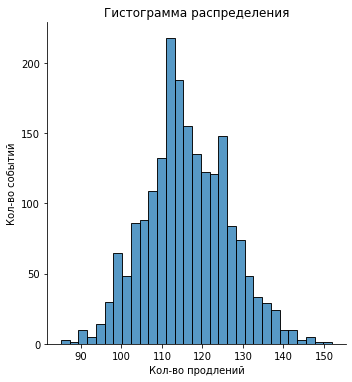

Минимальное кол-во промокодов, которое нужно разослать, чтобы вероятность не выполнить план в как минимум 100 продлений была
примерно 5% = 1161.


In [53]:
#Расчет и построение графика
promo_number = 1000
p = 0.1
target_success = 100
traget_probability = 0.05

while traget_probability < binom.cdf(target_success-1, promo_number, p):
    promo_number += 1
    
distr = random.binomial(n=promo_number, p=p, size=2000)

sns.displot(data=distr).set(title = 'Гистограмма распределения', xlabel ='Кол-во продлений', ylabel='Кол-во событий')

#ax_3.set_title('Гистограмма распределения')

plt.show()

print(f'Минимальное кол-во промокодов, которое нужно разослать, чтобы вероятность не выполнить план в как минимум {target_success} продлений была\nпримерно {round(traget_probability*100)}% = {promo_number}.')

### 
Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

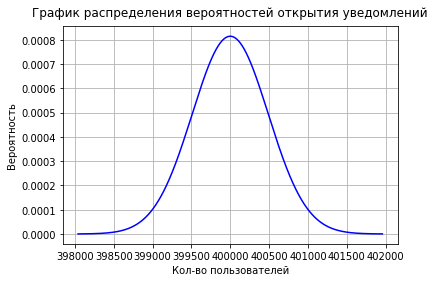

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет примерно 15.37%


In [54]:
#Расчет и построение графика
n = 1000000
p = .4
target = 399500

mu = n * p
sigma = sqrt(n * p * (1 - p))

left = mu - 4 * sigma
right = mu + 4 * sigma

x = np.arange(left, right, 1)

plt.title('График распределения вероятностей открытия уведомлений', pad=10)
plt.xlabel('Кол-во пользователей')
plt.ylabel('Вероятность')

plt.plot(x, st.norm.pdf(x, mu, sigma), color='blue')

plt.grid(True)

plt.show()

distr = st.norm(mu, sigma)

print(f'Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет примерно {round(distr.cdf(399500)*100, 2)}%')

### Промежуточный вывод после построения распределений

**№7.1** 

Минимальное кол-во промокодов, которое нужно разослать, чтобы вероятность не выполнить план в 100 продлений была примерно 5%, при условии что вероятность продления подписки составляет 10%, равно 1161.

**№7.2**

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет примерно 15.37% при миллионе разосланных уведомлений и 40%ой вероятности открытия уведомления каждым пользователем.

## Общий вывод
<a id='section_8'></a>

В процессе исследования данных о пользователях популярного сервиса аренды самокатов **GoFast**, было сделано следующее:

**1. Загрузка данных**
 - **users_go**: 1565 строк.
 - **rides_go**: 18065 строк.
 - **subscriptions_go**: 2 строки.

**2. Предобработка данных**
- **users_go**
 - Удален 31 дубликат.
 - Были проверены столбцы **city** и **name** на неявные дубликаты, аномалий найдено не было.
- **rides_go**
 - Тип данных столбца **date** изменен на *datetime*.
 - Вся выбока только за 2021 год.
 - Создан столбец с номером месяца поездки.
 
**3. Исследовательский анализ**
**Распределение пользователей по городам:**
- Больше всего пользуются арендой самокатов в более южных городах, где сезон проката больше, станно на этом фоне выглят Екатеринбург, который даже севернее Москвы.

**Распределение пользователей по типу подписки:**
- Пользователей с подпиской меньше (45%), чем пользователей без подписки (55%).

**Возраст пользователей:**
- Распределение стремится к нормальному.
- Наибоолее распространенный возраст - 25 лет, минимальный - 12 лет, максимальный - 43 года, большинство пользователй находится в диапазоне от 20 лет до 30 лет.

**Дальность поездок:**
- Есть два всплеска на 600 м и 3000 м.
- Распределение стремится к нормальному, если не считать первый всплеск.
- Большинство поездок находятся в диапазоне от 2500 м до 4000 м, медиана на 3100 м, первый квартиль - 2550 м, третий квартиль - 3800 м, минимальная дальность поездки - 1 м (видимо человек передумал), максимальная - 7200 м.

**Длительность поездок**
- Распределение стремится к нормальному.
- Большинство поездок находится в дипазоне от 10 мин до 25 мин, медиана - 18 мин, первый квартиль - 14 мин, третий квартиль - 22 мин, минисальная длительность поездки - 0.5 мин, максимальная - 41 мин.
- Была исправлена аномалия с поезками в пол минуты, оказалось время в некоторых строках было указано в часах.

**4. Объединение данных**
1. Был создан датафрем с объединенными данными из исходных.
2. Из объединенного датафрейма было создано 2 датафрема: в одном пользователи с подпиской, в другом без подписки.

**ultra:**
- Дальность поездок имеют два всплеска на 1000 м и 3000 м, большинство поездок в диапазоне от 2500 м до 4000 м, минимальная дальность - 244 м, максимальная дальность - 5700 м, медиана 3150 м, первый квартиль - 2800 м, третий квартиль 3560 м, стандартное отклонение 837 м.
- Длительность поездок нормально распределена, большинство поездок находится в диапазоне от 10 мин до 25 мин, минимальная длительность - 4 мин, максимальная - 41 мин, медиана - 18 мин, первый квартиль - 14 мин, третий квартиль - 22 мин, стандартное отклонение - 5.6 мин.

**free:**
- Дальность поездок имеют два всплеска на 500 м и 3000 м, большинство поездок в диапазоне от 2000 м до 5000 м, минимальная дальность - 1 м, максимальная дальность - 7200 м, медиана 3100 м, первый квартиль - 2400 м, третий квартиль 3900 м, стандартное отклонение 1246 м.
- Длительность поездок нормально распределена, большинство поездок находится в диапазоне от 5 мин до 30 мин, минимальная длительность - 2 мин, максимальная - 35 мин, медиана - 17 мин, первый квартиль - 13 мин, третий квартиль - 22 мин, стандартное отклонение 6 мин.

**Сравнение ultra и free:**
- Дальности поездок пользователей без подписки сильнее разбросаны, чем дальности поездок пользователей с подпиской, медианы и средние примерно равны минимальная дальность у пользователей с подпиской больше, чем у пользователей без подписки, а максимальная наоборот меньше.
- Длительности поездок пользователей без подписки чуть сильнее разбросаны, чем длительности поездок пользователей с подпиской, медианы и средние примерно равны, минимальная и максимальная длительность у пользователей с подпиской больше, чем у пользователей без подписки.

**5. Подсчет выручки**
1. Округлили длительности поездок в большую сторону в **full_data**.
2. На основе **full_data** создали датафрейм **aggregated_rides**, где найдено суммарное расстояние, кол-во поездок и суммарное кол-во поездок для каждого пользователя за каждый месяц.
3. В **aggregated_rides** был добавлени столбец с помесячной выручкой от каждого пользователя.

**6. Проверка гипотез**

**6.1**: По результатам проверки, отвергли гипотезу H_0: Среднее время поездки пользователей с подпиской = среднее время поездки пользователей без подписки, в пользу H_1: Среднее время поездки пользователей с подпиской > среднее время поездки пользователей без подписки.

**6.2**: Мы увеличили свою увепенность в том, что среднее время поездки пользователей с подпиской меньше 3130 метров, а значит износ самокатов находится на оптимальнос уровне.

**6.3**: По результатам проверки, отверли гипотезу H_0: Помесячная выручка от пользователей с подпиской = помесячная выручка от пользователей без подписки  в пользу H_1: Помесячная выручка от пользователей с подпиской > помесячная выручка от пользователей без подписки.

**6.4**: Мы хотим проверить гипотезу двух зависимых выборок, следовательно используем: st.ttest_rel(), гипотеза должна быть односторонней.

**7. Распределения**

**№7.1** 

Минимальное кол-во промокодов, которое нужно разослать, чтобы вероятность не выполнить план в 100 продлений была примерно 5%, при условии что вероятность продления подписки составляет 10%, равно 1172.

**№7.2**

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет примерно 15.37% при миллионе разосланных уведомлений и 40%ой вероятности открытия уведомления каждым пользователем.

**8. Рекомендации**

Есть проблема с данными о длительности поездок, где бывают поездки длительностью меньше минуты и дальностью в 5 км (столбец **duration** таблицы **rides_go**), на самом деле время в этих строках указано в часах, а не в минутах. Это явная ошибка, которую стоит исправить.

**9. Резюме**

На основе проведенного исследования, можно сказать, что пользователи с подпиской более выгодны компании, чем пользователи без подписки.